In [ ]:
from langgraph.graph import START, END, StateGraph
from langgraph.types import Send, interrupt
from typing import TypedDict
from openai import OpenAI
from langchain.chat_models import init_chat_model
from typing_extensions import Annotated

import subprocess
import textwrap
import operator
import base64

llm = init_chat_model("openai:gpt-4o-mini")

class State(TypedDict):
    video_file: str
    audio_file: str
    transcription: str
    summaries: Annotated[list[str], operator.add]
    thumbnail_prompts: Annotated[list[str], operator.add]
    thumbnail_sketches: Annotated[list[str], operator.add]
    final_summary: str
    user_feedback: str
    chosen_prompt: str
    

In [ ]:
def extract_audio(state: State):
    output_file = state["video_file"].replace("mp4", "mp3")
    command = [
        "ffmpeg",
        "-i",
        state["video_file"],
        "-filter:a",
        "atempo=2.0", # pay an half
        "-y",
        output_file,
    ]
    subprocess.run(command)
    
    return { "audio_file": output_file }

def transcribe_audio(state: State):
    client = OpenAI()
    with open(state["audio_file"], "rb") as f:
        transcription = client.audio.transcriptions.create(
            model="whisper-1",
            response_format="text",
            file=f,
            language="ko", # hint to model
            # prompt="Mizaki" # Give hint to model, words list
        )
        
    return { "transcription": transcription }

def dispatch_summarizers(state: State):
    transcription = state["transcription"]
    chunks = []
    for i, chunk in enumerate(textwrap.wrap(transcription, 500)):
        chunks.append({"id": i+1, "chunk": chunk})
    
    return [Send(summarize_chunk.__name__, chunk) for chunk in chunks]

def summarize_chunk(chunk: str):
    chunk_id = chunk["id"]
    chunk = chunk["chunk"]

    response = llm.invoke(f"""
    Please summarize the following text and response in Korean.

    Text: {chunk}
    """)
    summary = f"[Chunk {chunk_id}] {response.content}"

    return {"summaries": [summary]}

def mega_summary(state: State):
    all_summaries = "\n".join(state["summaries"])
    response = llm.invoke(f"""
    You are given multiple summaries of different chunks from a video transcription.
    Please create a comprehensive final summary that combines all the key points.
    Individual summaries:

    {all_summaries}
    """)

    return {"final_summary": response.content}

def dispatch_artists(state: State):
    return [Send(generate_thumbnail.__name__, {"id": i, "summary": state["final_summary"]}) for i in range(5)]

def generate_thumbnail(args):
    concept_id = args["id"]
    summary = args["summary"]

    prompt = f"""
    Based on this video summary, create a detailed visual prompt for a YouTube thumbnail.

    Create a detailed prompt for generating a thumbnail image that would attract viewers. Include:
        - Main visual elements
        - Color scheme
        - Text overlay suggestions
        - Overall composition
    
    Summary: {summary}
    """

    response = llm.invoke(prompt)

    thumbnail_prompt = response.content

    client = OpenAI()
    result = client.images.generate(
        model="gpt-image-1",
        prompt=thumbnail_prompt,
        quality="low",
        moderation="low",
        size="auto",
    ) # base64
    image_bytes = base64.b64decode(result.data[0].b64_json)
    
    filename = f"thumbnail_{concept_id}.jpg"

    with open(filename, "wb") as f:
        f.write(image_bytes)

    return {"tumbnail_prompt": [thumbnail_prompt], "thumbnail_sketches": [filename]}

def human_feedback(state: State):
    answer = interrupt({
        "chosen_thumbnail": "Which thumbnail do you like the most?", 
        "feedback": "Provide any feedback or changes you'd like for the final thumbnail."
    })

    user_feedback = answer["user_feedback"]
    chosen_prompt = answer["chosen_prompt"]

    return {"user_feedback": user_feedback, "chosen_prompt": state["thumbnail_prompts"][chosen_prompt-1]}

def generate_hd_thumbnail(state: State):
    chosen_prompt = state["chosen_prompt"]
    user_feedback = state["user_feedback"]
    
    prompt = f"""
    You are a professional YouTube thumbnail designer. Take this original thumbnail prompt and create an enhanced version that incorporates the user's specific feedback.

    ORIGINAL PROMPT:
    {chosen_prompt}

    USER FEEDBACK TO INCORPORATE:
    {user_feedback}

    Create an enhanced prompt that:
        1. Maintains the core concept from the original prompt
        2. Specifically addresses and implements the user's feedback requests
        3. Adds professional YouTube thumbnail specifications:
            - High contrast and bold visual elements
            - Clear focal points that draw the eye
            - Professional lighting and composition
            - Optimal text placement and readability with generous padding from edges
            - Colors that pop and grab attention
            - Elements that work well at small thumbnail sizes
            - IMPORTANT: Always ensure adequate  white space/padding between any text and the image borders
    """

    response = llm.invoke(prompt)
    
    final_thumbnail_prompt = response.content
    
    client = OpenAI()
    result = client.images.generate(
        model="gpt-image-1",
        prompt=final_thumbnail_prompt,
        quality="hd",
        moderation="low",
        size="auto",
    ) # base64
    image_bytes = base64.b64decode(result.data[0].b64_json)
    
    filename = "thumbnail_final.jpg"

    with open(filename, "wb") as f:
        f.write(image_bytes)


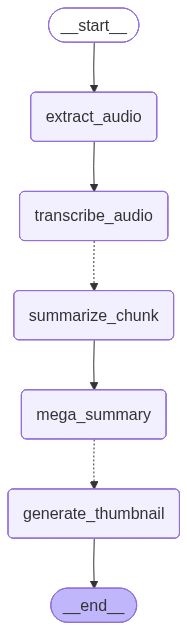

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node(extract_audio.__name__, extract_audio)
graph_builder.add_node(transcribe_audio.__name__, transcribe_audio)
graph_builder.add_node(summarize_chunk.__name__, summarize_chunk)
graph_builder.add_node(mega_summary.__name__, mega_summary)
graph_builder.add_node(generate_thumbnail.__name__, generate_thumbnail)
graph_builder.add_node(human_feedback.__name__, human_feedback)
graph_builder.add_node(generate_hd_thumbnail.__name__, generate_hd_thumbnail)

graph_builder.add_edge(START, extract_audio.__name__)
graph_builder.add_edge(extract_audio.__name__, transcribe_audio.__name__)
graph_builder.add_conditional_edges(transcribe_audio.__name__, dispatch_summarizers, [summarize_chunk.__name__])
graph_builder.add_edge(summarize_chunk.__name__, mega_summary.__name__)
graph_builder.add_conditional_edges(mega_summary.__name__, dispatch_artists, [generate_thumbnail.__name__])
graph_builder.add_edge(generate_thumbnail.__name__, human_feedback.__name__)
graph_builder.add_edge(human_feedback.__name__, generate_hd_thumbnail.__name__)
graph_builder.add_edge(generate_hd_thumbnail.__name__, END)

graph = graph_builder.compile()

graph

In [11]:
graph.invoke({"video_file": "lifeof20.mp4"})

ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.0.13.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

PermissionDeniedError: Error code: 403 - {'error': {'message': 'Your organization must be verified to use the model `gpt-image-1`. Please go to: https://platform.openai.com/settings/organization/general and click on Verify Organization. If you just verified, it can take up to 15 minutes for access to propagate.', 'type': 'invalid_request_error', 'param': None, 'code': None}}